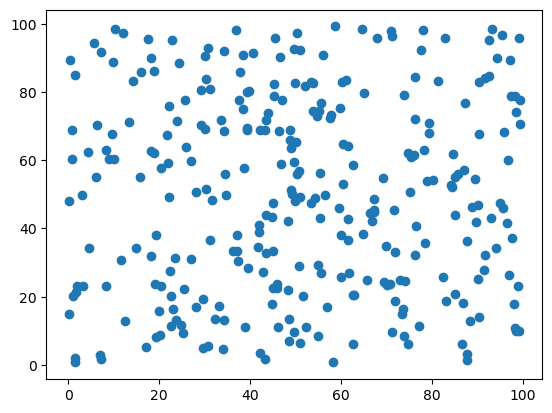

In [2]:
import numpy as np
import python_tsp as tsp
from python_tsp.distances import euclidean_distance_matrix
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing
import matplotlib.pyplot as plt

size, magnitude = 300, 100
X = magnitude*np.random.rand(size)
Y = magnitude*np.random.rand(size)
locations = np.stack((X, Y), axis=1)
distance_matrix = euclidean_distance_matrix(locations)
route, dis = solve_tsp_simulated_annealing(distance_matrix)
plt.scatter(X, Y)

In [4]:
def plot_routes(X, Y, locations, route, tsp_dis, wlk_dis=0):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title('Optimized tour')
    # ax.scatter(X, Y)
    distance = 0.0
    N = locations.shape[0]
    start_node = 0
    for i in range(N):
        start_pos = locations[start_node]
        next_node = route[i+1] if i < N-1 else route[0]
        end_pos = locations[next_node]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        distance += np.linalg.norm(end_pos - start_pos)
        start_node = next_node
    textstr = "N nodes: %d\nTotal TSP length: %.3f\nTotal Wlk length: %.3f\nTotal length: %.3f" % (N, tsp_dis, wlk_dis, tsp_dis+wlk_dis)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, # Textbox
        verticalalignment='top', bbox=props)
    return ax


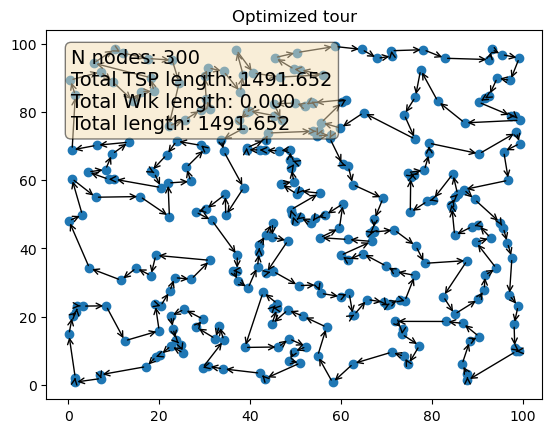

In [5]:
ax = plot_routes(X, Y, locations, route, dis)
ax.scatter(X, Y)

In [6]:
import sklearn.cluster as clst

num_fixed_stops = 100
kmeans = clst.KMeans(n_clusters=num_fixed_stops, random_state=0)
clusters = kmeans.fit(locations)

d:\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


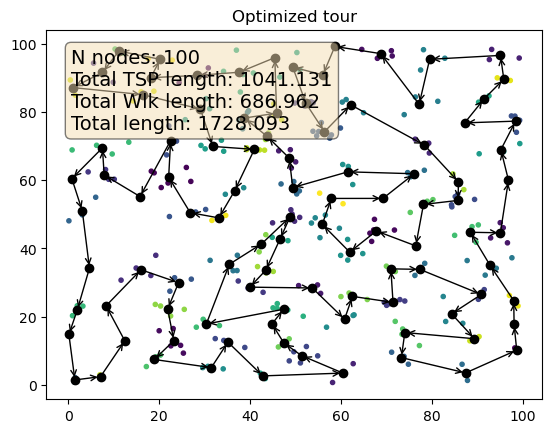

In [15]:
labels, centers = clusters.labels_, clusters.cluster_centers_
center_X, center_Y = centers[:, 0], centers[:, 1]
# plt.scatter(center_X, center_Y, c='black')
# plt.scatter(X, Y,s=9, c=labels)
center_distance_matrix = euclidean_distance_matrix(centers)
center_route, center_dis = solve_tsp_simulated_annealing(center_distance_matrix)
center_ctgr = np.array([centers[i] for i in labels])
wlk_dis = np.sum(np.linalg.norm(locations - center_ctgr, axis=1))
ax = plot_routes(center_X, center_Y, centers, center_route, center_dis, wlk_dis)
ax.scatter(X, Y, s=9, c=labels)
ax.scatter(center_X, center_Y, c='black')

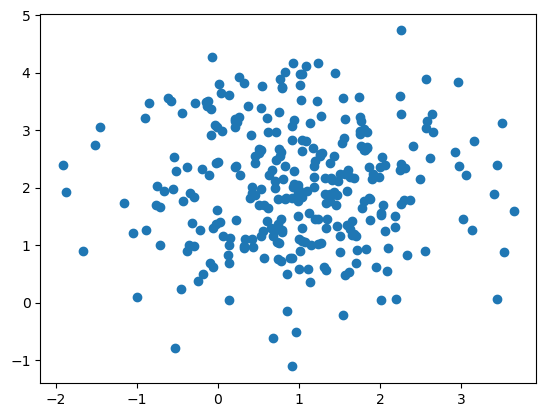

In [11]:
normal_locations = np.random.multivariate_normal(np.array([1, 2]), cov = np.eye(2), size=(size,))
normal_X, normal_Y = normal_locations[:, 0], normal_locations[:, 1]
normal_distance_matrix = euclidean_distance_matrix(normal_locations)
noraml_route, normal_dis = solve_tsp_simulated_annealing(normal_distance_matrix)
plt.scatter(normal_X, normal_Y)

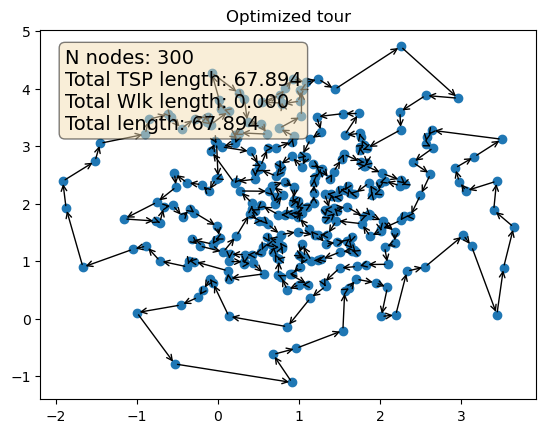

In [12]:
ax = plot_routes(normal_X, normal_Y, normal_locations, noraml_route, normal_dis)
ax.scatter(normal_X, normal_Y)

d:\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


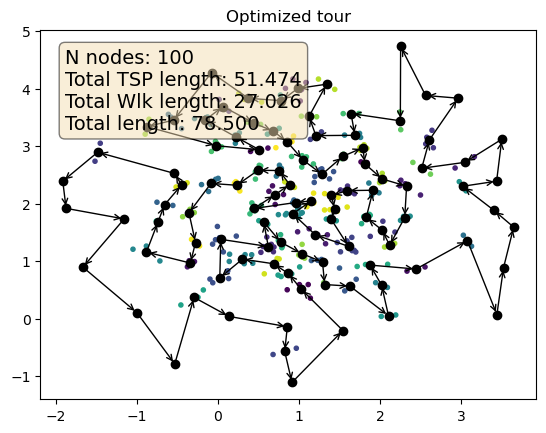

In [19]:
normal_clusters = kmeans.fit(normal_locations)
labels, centers = normal_clusters.labels_, normal_clusters.cluster_centers_
center_X, center_Y = centers[:, 0], centers[:, 1]
# plt.scatter(center_X, center_Y, c='black')
# plt.scatter(X, Y,s=9, c=labels)
center_distance_matrix = euclidean_distance_matrix(centers)
center_route, center_dis = solve_tsp_simulated_annealing(center_distance_matrix)
center_ctgr = np.array([centers[i] for i in labels])
wlk_dis = np.sum(np.linalg.norm(normal_locations - center_ctgr, axis=1))
ax = plot_routes(center_X, center_Y, centers, center_route, center_dis, wlk_dis)
ax.scatter(normal_X, normal_Y, s=9, c=labels)
ax.scatter(center_X, center_Y, c='black')

In [8]:
import numpy as np

arr = np.array([1,2,3])
for i in arr:
    print(i)

np.floor(arr*0.3)
np.arange(0, 1, 0.1)

1
2
3


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])